In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from Modules import plot_ax_violin
from Modules import read_data
from Modules import sholl_analysis

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def get_ephys_data(ephys_types = ['AP peak amplitude (mV)', 'AP halfwidth (ms)', 'Attenuation'],
                 ephys_names = ['AP amplitude (mV)', 'AP halfwidth (ms)', 'Attenuation']
                ):
    # keep only vBC cells
    df_ephys = plot_ax_violin.read_ephys_data('Lab_Pvalb')
    df_ephys.index = df_ephys.index.get_level_values(0)
    df_ephys.index.name = 'Cell'
    df_labels = read_data.read_dataset_labels('Lab_Pvalb')
    df_labels = df_labels.loc[df_labels.index.isin(df_ephys.index)]
    df_labels = df_labels.loc[df_labels.CellType == 'vBC'].sort_values('Age')
    df_ephys = df_ephys.loc[df_labels.index, ephys_types].copy()
    df_ephys.index = df_labels.Age
    df_ephys.columns = ephys_names
    
    return df_ephys

def get_ion_signif(df_ion):
    df_young = df_ion.xs('<P21', level='Category', axis=1)
    df_old = df_ion.xs('>P21', level='Category', axis=1)
    df_stat = pd.DataFrame(np.NaN, index=df_ion.index, columns=['Score', 'Pval'])
    for gene in df_stat.index:
        df_stat.loc[gene] = mannwhitneyu(df_young.loc[gene], df_old.loc[gene], alternative='two-sided')
    df_stat.Pval = df_stat.Pval
    df_stat.sort_values('Pval', inplace=True)
    df_stat['Padj'] = multitest.multipletests(df_stat.Pval.values, method='fdr_bh')[1]
    
    arrays = [['<P21'], ['>P21']]
    names = ('Category_1', 'Category_2')
    index = pd.MultiIndex.from_arrays(arrays, names=names)
    df_fdr = pd.DataFrame(np.NaN, index=index, columns=df_stat.index)
    df_fdr.iloc[0,:] = df_stat.Padj.values

    return df_stat, df_fdr

def plot_ephys_by_age(df_ephys, fig, top=0.90):
    xvals = df_ephys.index.values
    width = .187
    height = width / 11 * 8.5 * 0.7
    
    #fig.text(.1, top+.01, 'a', fontsize=14, ha='left', va='top')
    
    color_dict = sholl_analysis.get_age_color_converter()
    colors = df_ephys.index.map(color_dict)
    
    for col, val in enumerate(df_ephys.columns):
        ax = fig.add_axes([.16 + 0.25*col, top-height, width, height])
        ax.tick_params(size=1, labelsize=6)
        ax.set_xlabel('Age (days)', fontsize=7)
        ax.set_ylabel(val, fontsize=7)
        
        yvals = df_ephys[val].values
        
        xshift = xvals + (np.random.rand(xvals.size)-.5) * 1
        yshift = yvals + (np.random.rand(yvals.size)-.5) * yvals.max() / 50
        approx = lowess(yshift, xshift, frac=.66, is_sorted=False, return_sorted=True)
    
        ax.scatter(xvals, yvals, facecolor=colors, edgecolor='k', linewidth=.25, s=16)
        ax.plot(approx[:,0], approx[:,1], color='black')
        
        ylow, yhigh = yvals.min(), yvals.max()
        xlow, xhigh = xvals.min()-1, xvals.max()+1
        ydiff = (yhigh-ylow)*.02
        ylow = ylow-ydiff
        yhigh = yhigh+ydiff
        ax.axis([xlow,xhigh,ylow,yhigh])
        
        ax.plot([21,21], [ylow,yhigh], linewidth=1, color='gray', linestyle='dashed')
    
    ax = fig.add_axes([.89, top-height, 0.01, height])
    sholl_analysis.plot_age_scale(xvals, ax, orientation='vertical')
        
    return

In [3]:
%%time

df_ephys = get_ephys_data()

CPU times: user 11.8 ms, sys: 3.91 ms, total: 15.7 ms
Wall time: 16.1 ms


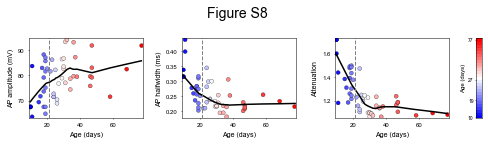

CPU times: user 1.19 s, sys: 683 ms, total: 1.87 s
Wall time: 720 ms


In [4]:
%%time

fig = plt.figure(figsize=(8.5,11))
fig.suptitle('Figure S8', fontsize=14, y=.93)
plot_ephys_by_age(df_ephys, fig, top=0.89)

fig.savefig('Figures/Figure S8.pdf')
plt.show()
plt.close()